In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score, BinaryAccuracy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


In [2]:
data = pd.read_csv('../datasets/filtered_ecg_signals.csv')

In [7]:
X = data.iloc[:, :-1] # features

y = data.iloc[:, -1] # labels

print(f"X: {X.shape}, y: {y.shape}")
print(f"X Head: {X.head()}")
print(f"y Head: {y.head()}")
print(f"X Info: {X.info()}")
print(f"y Info: {y.info()}")
print(f"X Description: {X.describe()}")
print(f"y Description: {y.describe()}")
print(f"X tail: {X.tail()}")
print(f"y tail: {y.tail()}")


X: (14552, 187), y: (14552,)
X Head:           0         1         2         3         4         5         6  \
0 -0.008763 -0.135806 -0.577641 -0.933554 -0.914556 -0.802527 -0.793689   
1  0.063421 -0.155628 -0.509913 -0.825991 -0.878442 -0.729940 -0.603986   
2  0.022680 -0.112090 -0.397416 -0.691927 -0.824502 -0.812865 -0.754373   
3  0.019383 -0.517860 -0.852588 -0.900991 -0.833111 -0.827430 -0.843862   
4  0.015131 -0.192058 -0.649444 -0.894625 -0.798463 -0.757614 -0.810288   

          7         8         9  ...       177       178       179       180  \
0 -0.799524 -0.782339 -0.773429  ... -0.024296 -0.025436 -0.026514 -0.027526   
1 -0.570665 -0.548560 -0.509061  ... -0.022942 -0.022344 -0.021756 -0.021177   
2 -0.717723 -0.709217 -0.699311  ... -0.126305 -0.123111 -0.119005 -0.114365   
3 -0.824888 -0.809077 -0.804276  ... -0.042515 -0.043941 -0.045268 -0.046491   
4 -0.793197 -0.763684 -0.765459  ... -0.045252 -0.046334 -0.047327 -0.048227   

        181       182       183

<Axes: xlabel='label', ylabel='count'>

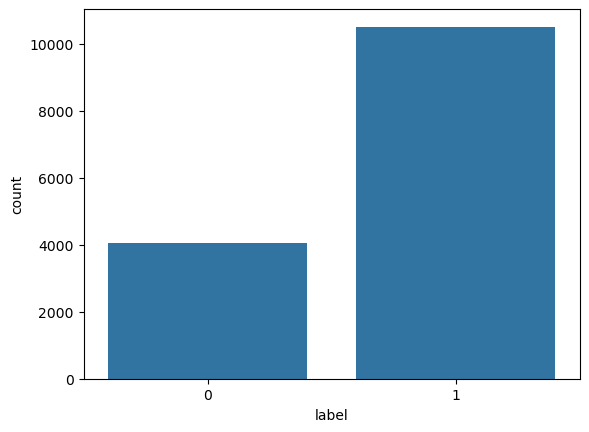

In [8]:
sns.countplot(x=data['label'])

### Let's split data 

Since our data is imbalanced with only about 4000 normal points and 10000 abnormal points, we will use stratified splitting.

A stratified split means you divide the data so that each group (or class) keeps the same balance in both the training and testing sets as it had in the full dataset.

Also doing a 70/15/15 split of Train, Test and Validation.

In [35]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp)

'''
To check if stratification worked correctly, we will calculate:

The percentage of abnormal samples in your original dataset
The percentage of abnormal samples in your training set
The percentage of abnormal samples in your test set
'''

print(f"Percentage of abnormal samples in original dataset: {y.value_counts(normalize=True)}")
print(f"Percentage of abnormal samples in training set: {y_train.value_counts(normalize=True)}")
print(f"Percentage of abnormal samples in test set: {y_test.value_counts(normalize=True)}")


# Total number of samples in each set
print(f"Total number of samples in training set: {len(X_train)}")
print(f"Total number of samples in test set: {len(X_test)}")
print(f"Total number of samples in validation set: {len(X_val)}")
print(f"Total number of samples in y_train dataset: {len(y_train)}")
print(f"Total number of samples in y_test dataset: {len(y_test)}")
print(f"Total number of samples in y_val dataset: {len(y_val)}")

# Class distribution in each set
print(f"Class distribution in training set: {y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set: {y_test.value_counts(normalize=True)}")
print(f"Class distribution in validation set: {y_val.value_counts(normalize=True)}")



Percentage of abnormal samples in original dataset: label
1    0.721963
0    0.278037
Name: proportion, dtype: float64
Percentage of abnormal samples in training set: label
1    0.721963
0    0.278037
Name: proportion, dtype: float64
Percentage of abnormal samples in test set: label
1    0.721942
0    0.278058
Name: proportion, dtype: float64
Total number of samples in training set: 10513
Total number of samples in test set: 2183
Total number of samples in validation set: 1856
Total number of samples in y_train dataset: 10513
Total number of samples in y_test dataset: 2183
Total number of samples in y_val dataset: 1856
Class distribution in training set: label
1    0.721963
0    0.278037
Name: proportion, dtype: float64
Class distribution in test set: label
1    0.721942
0    0.278058
Name: proportion, dtype: float64
Class distribution in validation set: label
1    0.721983
0    0.278017
Name: proportion, dtype: float64


### It works as we can see ratio is very similar of about 72 to 28 in every subset

## Now let's train the model by balancing and giving more weight to the minority class which is the normal one

In [40]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights}")

# Convert class weights to a dictionary
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print(f"Class weights dictionary: {class_weights_dict}")



Class weights: [1.79832364 0.69255599]
Class weights dictionary: {0: 1.798323640095792, 1: 0.6925559947299078}


What the 'balanced' class weighting does behind the scenes:

It automatically calculates weights inversely proportional to class frequencies
It gives higher importance to underrepresented classes (in our case, normal ECGs)
It makes the model "pay more attention" to errors on minority classes during training
It helps prevent the model from simply predicting the majority class all the time

Inversely proportional in simple words means "goes in the opposite direction" - when one value goes up, the other goes down. For our class weights, it means the less frequent a class is in our data, the higher weight we give it.
The ratio between our weights (~2.6) corresponds well with our class imbalance ratio (~2.6, since we have about 72% abnormal and 28% normal). This suggests the weighting is appropriately calibrated to our dataset's specific imbalance.
The true effectiveness of this weighting approach will only be fully validated once we train our model and evaluate its performance across metrics like accuracy, precision, recall, and F1 score. The weights look theoretically appropriate, but their practical impact depends on how our CNN model interacts with the specific patterns in our ECG data.

In [ ]:
# Reshape the data to be 3D (samples, timesteps, features) Since we have only one feature (the ECG signal), the number of features is 1.
X_train_array = X_train.values  
X_val_array = X_val.values 
X_test_array = X_test.values  

X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_val_reshaped = X_val_array.reshape(X_val_array.shape[0], X_val_array.shape[1], 1)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)
print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")

model = Sequential()
# Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
# MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))
# Flatten layer
model.add(Flatten())
# Dense layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train, 
                    epochs=30, 
                    batch_size=32,
                    validation_data=(X_val_reshaped, y_val),
                    class_weight=class_weights_dict)

test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")



X_train_reshaped shape: (10513, 187, 1)
X_val_reshaped shape: (1856, 187, 1)
X_test_reshaped shape: (2183, 187, 1)
Epoch 1/30
329/329 [==============================] - 1s 2ms/step - loss: 0.5341 - accuracy: 0.7301 - val_loss: 0.4729 - val_accuracy: 0.7694
Epoch 2/30
329/329 [==============================] - 1s 2ms/step - loss: 0.4356 - accuracy: 0.7878 - val_loss: 0.4299 - val_accuracy: 0.8006
Epoch 3/30
329/329 [==============================] - 1s 2ms/step - loss: 0.4143 - accuracy: 0.7998 - val_loss: 0.3863 - val_accuracy: 0.8265
Epoch 4/30
329/329 [==============================] - 1s 2ms/step - loss: 0.3967 - accuracy: 0.8123 - val_loss: 0.4030 - val_accuracy: 0.8125
Epoch 5/30
329/329 [==============================] - 1s 2ms/step - loss: 0.3854 - accuracy: 0.8191 - val_loss: 0.4213 - val_accuracy: 0.7963
Epoch 6/30
329/329 [==============================] - 1s 2ms/step - loss: 0.3824 - accuracy: 0.8191 - val_loss: 0.3576 - val_accuracy: 0.8416
Epoch 7/30
329/329 [=============

In [91]:
# Custom function for F1 score calculation
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), K.floatx())
    
    # Calculate true positives, false positives, and false negatives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred_binary, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_binary, 0, 1)))
    
    # Calculate precision and recall
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    # Calculate F1 score
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

def evaluate_model(X_train_reshaped, y_train, X_test_reshaped, y_test, class_weights_dict):
    model = Sequential()
    
    # First Conv1D layer with BatchNormalization
    model.add(Conv1D(filters=32, kernel_size=3, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    
    # First MaxPooling1D layer
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))  # First dropout layer
    
    # Second Conv1D layer with BatchNormalization
    model.add(Conv1D(filters=64, kernel_size=3))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    
    # Second MaxPooling1D layer
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))  # Second dropout layer
    
    # Flatten layer
    model.add(Flatten())
    
    # Added a dense layer before the output
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))  # Third dropout layer with higher rate
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', Precision(), Recall(), AUC(), f1_score])
    
    # Train model
    model.fit(X_train_reshaped, y_train, 
              epochs=30, 
              batch_size=32,
              class_weight=class_weights_dict,
              verbose=0)
    
    # Evaluate model
    results = model.evaluate(X_test_reshaped, y_test, verbose=0)

    metrics = {
        'loss': results[0],
        'accuracy': results[1],
        'precision': results[2],
        'recall': results[3],
        'auc': results[4],
        'f1_score': results[5]
    }
    return metrics


In [ ]:
def run_experiment(X_train, y_train, X_test, y_test, class_weights_dict, repeats=1):
    # Reshape data
    X_train_array = X_train.values  
    X_test_array = X_test.values  
    
    X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
    X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)
    
    all_metrics = {
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'auc': [],
        'f1_score': []
    }

    for r in range(repeats):
        metrics = evaluate_model(X_train_reshaped, y_train, X_test_reshaped, y_test, class_weights_dict)
        
        for key in all_metrics.keys():
            all_metrics[key].append(metrics[key])

        # Summary of metrics for this repeat
        print(f"Repeat {r+1}/{repeats}:")
        for key, value in all_metrics.items():
            print(f"{key}: {value * 100:.2f}%")
        
        
    # Summary of all repeats
    for metric_name, values in all_metrics.items():
        m, s = np.mean(values), np.std(values)
        print(f'{metric_name.capitalize()}: {m:.3f}% (+/-{s:.3f})')

    return all_metrics



# Run the experiment with 10 repeats
scores = run_experiment(X_train, y_train, X_test, y_test, class_weights_dict, repeats=1)

Repeat 1/1:
loss: 11.66%
accuracy: 95.92%
precision: 97.88%
recall: 96.45%
auc: 98.92%
f1_score: 97.15%
Loss: 0.117% (+/-0.000)
Accuracy: 0.959% (+/-0.000)
Precision: 0.979% (+/-0.000)
Recall: 0.964% (+/-0.000)
Auc: 0.989% (+/-0.000)
F1_score: 0.972% (+/-0.000)
